In [1]:
import os
import sys

# Get the current working directory of the notebook
current_dir = os.getcwd()

# Check if the last part of the path is 'notebooks'
if os.path.basename(current_dir) == 'notebooks':
    # If it is, then change the directory to the parent folder (the project root)
    project_root = os.path.dirname(current_dir)
    os.chdir(project_root)

# Verify the new working directory
print(f"Current Working Directory has been set to: {os.getcwd()}")

# Add the project root to the Python path
# This makes sure Python can find your modules
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

Current Working Directory has been set to: /Users/rchhetri/C360 Projects/C360_metric_importance


In [102]:
# Magic commands to automatically reload modules
%load_ext autoreload
%autoreload 2

# Import your custom modules just like any other library!
from config import SnowflakeConfig
from snowflake_connector import SnowflakeConnector

# Import other necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Initialize your configuration and connector
sf_config = SnowflakeConfig()
connector = SnowflakeConnector(config=sf_config)

# Write your SQL query
query = """
  with filtered_data as 
(
select *
from dev.gtm.spreetham_customer_360_v5 
--  LATEST_EFFECTIVE_ACR between 100000 and 1000000
--  and SALES_HIER_GEO in ('AMER')
),
min_accnt_date as 
(
select SUBSCRIPTION_ACCOUNT_ID, SFDC_ACCOUNT_NAME, min(subscription_term_start_date) as min_sub_date
from dev.gtm.spreetham_customer_360_v5 
group by SUBSCRIPTION_ACCOUNT_ID, SFDC_ACCOUNT_NAME
),
segments as (
select DATEDIFF(MONTH, m.min_sub_date, current_date()) as accnt_age_mths, f.*,
 CASE WHEN DATEDIFF(MONTH, m.min_sub_date, current_date()) <=6 AND latest_buying_program = 'Volume Plan' THEN 'Early Volume Plan'
     WHEN DATEDIFF(MONTH, m.min_sub_date, current_date()) > 6 AND latest_buying_program = 'Volume Plan' THEN 'Late Volume Plan'
     WHEN DATEDIFF(MONTH, m.min_sub_date, current_date()) <= 6 AND latest_buying_program = 'Savings Plan' THEN 'Early Savings Plan'
     WHEN DATEDIFF(MONTH, m.min_sub_date, current_date()) > 6 AND latest_buying_program = 'Savings Plan' THEN 'Late Savings Plan'
     WHEN latest_buying_program = 'PAYG' THEN 'PAYG' ELSE 'Others' END AS segment_name

from filtered_data f
left join min_accnt_date m
on f.SUBSCRIPTION_ACCOUNT_ID = m.SUBSCRIPTION_ACCOUNT_ID
and f.SFDC_ACCOUNT_NAME = m.SFDC_ACCOUNT_NAME
)

select *
from segments
where segment_name in ('Early Volume Plan','Early Savings Plan','Late Volume Plan','Late Savings Plan','PAYG');

"""

# Connect, execute the query, and close the connection
try:
    connector.connect()
    df_raw = connector.execute_query(query)
finally:
    connector.close()


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://newrelic.okta.com/app/snowflake/exkugjs4xeGHw0Vo10x7/sso/saml?SAMLRequest=lZJRb9owFIX%2FSuQ9J3ayQloLqFihBanrUEmYxpubXMAjsTNfpwn%2FfiaUqa3USnuz7HOuv3vPHVy3ZeE9g0Gp1ZCEASMeqEznUm2HJE1u%2FUvioRUqF4VWMCQHQHI9GqAoi4qPa7tTj%2FCnBrSeK6SQdw9DUhvFtUCJXIkSkNuML8ff73kUMF4ZbXWmC%2FLK8rlDIIKxjvBsyVE6vJ21Fae0aZqg%2BRpos6URY4yyK%2BpUR8mXs751PX2gDym7OOqdwskXL2zfpDqN4DOsp5MI%2BSxJFv7ixzIh3viMeqMV1iWYJZhnmUH6eH8CQEegoDFQyMwh%2BLmwQmOASjebQuwh02VVW1c2cCe6gZwWeitd5%2FPJkFR7meM6ZUlRy4ef9Wy1jSNzF7fT9Crvp9HTIZbr8TTqZeVu%2F2uaZsRbnaONjtHOEWuYq2Og1l2xqOezvh9eJizmUY%2BzOIij%2Fpp4ExeoVMJ2zvfUgd5b0dGJqqL%2FwCm0%2B3r7Gy9auJs1bKVD1sYUUdNjwOS0M7wjMKP%2FnsSAvra%2F7N%2BDi2Q%2BWWhX4ODdalMK%2B3FiYRB2NzL3N52UQylkMc5zA4guuaLQzY0BYd2aW1MDoaPTr28XffQX&RelayState=ver%3A1-h

In [7]:
df_raw.head()  # Display the first few rows of the DataFrame

,ACCNT_AGE_MTHS,SUBSCRIPTION_ACCOUNT_ID,EFFECTIVE_SUBSCRIPTION_ACCOUNT_ID,SFDC_ACCOUNT_ID,SFDC_ACCOUNT_NAME,REPORT_AS_OF_DT,REPORT_MONTH,BUYING_PROGRAM,LATEST_BUYING_PROGRAM,EFFECTIVE_ACR,...,OPEN_TICKETS,AVG_CSAT_SCORE,MTHLY_FTTR_50,CHURN_RISK_SCORE,SENTIMENT_SCORE,ENGAGEMENT_SCORE,MAXIMUM_DAYS_PAST_DUE,SUM_TOTAL_AMOUNT_DUE,NUMBER_OF_OPEN_INVOICES_DUE_BEFORE_MONTH_END,SEGMENT_NAME
0,37,377608,377608,0011U00001S8sn0QAB,Rapaport Technologies,2023-05-31,2023-05-01,Legacy,Savings Plan,16198.080000000,...,None,None,None,None,None,None,None,None,None,Late Savings Plan
1,37,377608,377608,0011U00001S8sn0QAB,Rapaport Technologies,2023-07-31,2023-07-01,PAYG + Core,Savings Plan,0E-9,...,None,None,None,None,None,None,0.00,0.00,0.00,Late Savings Plan
2,37,377608,377608,0011U00001S8sn0QAB,Rapaport Technologies,2024-01-31,2024-01-01,PAYG + Core,Savings Plan,0E-9,...,None,None,None,None,None,None,0.00,0.00,0.00,Late Savings Plan
3,37,377608,377608,0011U00001S8sn0QAB,Rapaport Technologies,2024-05-31,2024-05-01,PAYG + Core,Savings Plan,0E-9,...,None,None,None,None,None,None,0.00,0.00,0.00,Late Savings Plan
4,37,377608,377608,0011U00001S8sn0QAB,Rapaport Technologies,2023-08-31,2023-08-01,PAYG + Core,Savings Plan,0E-9,...,None,None,None,None,None,None,0.00,0.00,0.00,Late Savings Plan


In [8]:
df_raw.shape

(93972, 107)

In [9]:
df_raw.columns

Index(['ACCNT_AGE_MTHS', 'SUBSCRIPTION_ACCOUNT_ID',
       'EFFECTIVE_SUBSCRIPTION_ACCOUNT_ID', 'SFDC_ACCOUNT_ID',
       'SFDC_ACCOUNT_NAME', 'REPORT_AS_OF_DT', 'REPORT_MONTH',
       'BUYING_PROGRAM', 'LATEST_BUYING_PROGRAM', 'EFFECTIVE_ACR',
       ...
       'OPEN_TICKETS', 'AVG_CSAT_SCORE', 'MTHLY_FTTR_50', 'CHURN_RISK_SCORE',
       'SENTIMENT_SCORE', 'ENGAGEMENT_SCORE', 'MAXIMUM_DAYS_PAST_DUE',
       'SUM_TOTAL_AMOUNT_DUE', 'NUMBER_OF_OPEN_INVOICES_DUE_BEFORE_MONTH_END',
       'SEGMENT_NAME'],
      dtype='object', length=107)

In [19]:
adoption_score_columns = ['USER_ACTIVATION_PERCENTAGE_HSCORE', 'PRODUCT_STICKINESS_RATIO_HSCORE',
       'USER_STICKINESS_RATIO_HSCORE', 'PRODUCT_UTILIZATION_RATE_HSCORE']
engagement_score_columns = ['ENGAGEMENT_SCORE_HSCORE', 'OPEN_TICKETS_HSCORE','AVG_CSAT_SCORE_HSCORE']
risk_score_columns = ['PCT_P1_CASES_HSCORE', 'PCT_P1P2_CASES_HSCORE', 'RESOLUTION_RATE_HSCORE','CHURN_RISK_SCORE_HSCORE', 'SENTIMENT_SCORE_HSCORE','RENEWAL_URGENCY_MONTHS_HSCORE','MTHLY_FTTR_50_HSCORE']
financial_score_columns = ['REVENUE_GROWTH_HSCORE','OVERAGE_SCORE_HSCORE','CONTRACT_LENGTH_SCORE_HSCORE']

all_hscores = adoption_score_columns + engagement_score_columns + risk_score_columns + financial_score_columns
raw_columns = [col.split('_HSCORE')[0] for col in all_hscores if col.endswith('_HSCORE')]

In [26]:
df_raw.columns.tolist()

['ACCNT_AGE_MTHS',
 'SUBSCRIPTION_ACCOUNT_ID',
 'EFFECTIVE_SUBSCRIPTION_ACCOUNT_ID',
 'SFDC_ACCOUNT_ID',
 'SFDC_ACCOUNT_NAME',
 'REPORT_AS_OF_DT',
 'REPORT_MONTH',
 'BUYING_PROGRAM',
 'LATEST_BUYING_PROGRAM',
 'EFFECTIVE_ACR',
 'IS_CONTRACT_FLAG',
 'LATEST_EFFECTIVE_ACR',
 'BCM',
 'LATEST_BCM',
 'INGEST_BCM',
 'INGEST_UNIT_PRICE',
 'CCU_BCM',
 'CCU_UNIT_PRICE',
 'USERS_BCM',
 'USERS_UNIT_PRICE',
 'SUBSCRIPTION_TERM_START_DATE',
 'SUBSCRIPTION_TERM_END_DATE',
 'RENEWAL_DATE',
 'MULTIYEAR_FLAG',
 'TOTAL_ACR',
 'INDUSTRY',
 'PHYSICAL_COUNTRY',
 'SALES_HIER_GEO',
 'SALES_HIER_REGION',
 'SALES_HIER_SUB_REGION',
 'EMPLOYEES',
 'CHURN_INDICATOR',
 'CONTRACT_START_DATE',
 'MONTHS_SINCE_CONTRACT_START',
 'DAILY_ENGAGED_USERS',
 'DAU_R7D',
 'COMMITTED_USERS',
 'ROLLING_60_DAY_MEDIAN',
 'DENOM_USERS',
 'USER_ACTIVATION_PERCENTAGE',
 'ADV_USED_FEATURES',
 'TOTAL_ADV_FEATURES',
 'PRODUCT_STICKINESS_RATIO',
 'DAU_ACTUALS',
 'USED_FEATURES',
 'TOTAL_FEATURES_3_PERCENT',
 'DAU_R30D',
 'USER_STICKINESS

In [36]:
target_cols = ['PCT_M_PLUS_6_BCM','PCT_M_PLUS_3_BCM','PCT_M_PLUS_12_BCM']
attribute_cols = ['SUBSCRIPTION_ACCOUNT_ID',
 'EFFECTIVE_SUBSCRIPTION_ACCOUNT_ID',
 'SFDC_ACCOUNT_ID',
 'SFDC_ACCOUNT_NAME',
 'REPORT_AS_OF_DT',
 'REPORT_MONTH',
 'BUYING_PROGRAM',
 'LATEST_BUYING_PROGRAM',
 'EFFECTIVE_ACR',
 'IS_CONTRACT_FLAG',
 'LATEST_EFFECTIVE_ACR',
 'BCM',
 'INDUSTRY',
 'SALES_HIER_GEO',
  'MULTIYEAR_FLAG',
  'SEGMENT_NAME']

In [92]:
cols_to_keep = attribute_cols + raw_columns + target_cols
df = df_raw[cols_to_keep]

In [93]:
df
# Calculate null percentage for each column, grouped by SEGMENT_NAME
segment_null_pct = (
    df.groupby('SEGMENT_NAME')
    .apply(lambda g: g.isnull().mean() * 100)
)

segment_null_pct

/var/folders/vn/04tfqd6j3hjbf_jcx4zc00ph0000gp/T/ipykernel_33010/3687700859.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('SEGMENT_NAME')


,SUBSCRIPTION_ACCOUNT_ID,EFFECTIVE_SUBSCRIPTION_ACCOUNT_ID,SFDC_ACCOUNT_ID,SFDC_ACCOUNT_NAME,REPORT_AS_OF_DT,REPORT_MONTH,BUYING_PROGRAM,LATEST_BUYING_PROGRAM,EFFECTIVE_ACR,IS_CONTRACT_FLAG,LATEST_EFFECTIVE_ACR,BCM,INDUSTRY,SALES_HIER_GEO,MULTIYEAR_FLAG,SEGMENT_NAME,USER_ACTIVATION_PERCENTAGE,PRODUCT_STICKINESS_RATIO,USER_STICKINESS_RATIO,PRODUCT_UTILIZATION_RATE,POWER_USER_RETENTION_RATIO,POWER_USER_CONSUMPTION_SHARE,POWER_USERS_CURRENT_MONTH,ENGAGEMENT_SCORE,OPEN_TICKETS,AVG_CSAT_SCORE,PCT_P1P2_CASES,RESOLUTION_RATE,MTHLY_FTTR_50,CHURN_RISK_SCORE,SENTIMENT_SCORE,RENEWAL_URGENCY_MONTHS,TOTAL_COMPETITOR_AGENTS,REVENUE_GROWTH,OVERAGE_SCORE,CONTRACT_LENGTH_SCORE,MAXIMUM_DAYS_PAST_DUE,SUM_TOTAL_AMOUNT_DUE,PCT_M_PLUS_6_BCM,PCT_M_PLUS_3_BCM,PCT_M_PLUS_12_BCM
SEGMENT_NAME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Early Savings Plan,0.0,0.0,0.0,0.0,0.0,0.0,6.666667,0.0,0.0,0.0,0.0,6.666667,15.555556,0.0,5.185185,0.0,41.481481,0.740741,0.0,0.000000,29.629630,14.814815,29.629630,22.962963,62.222222,95.555556,77.037037,62.222222,62.222222,77.777778,22.962963,28.148148,75.555556,25.185185,100.000000,6.666667,49.629630,49.629630,6.666667,6.666667,6.666667
Early Volume Plan,0.0,0.0,0.0,0.0,0.0,0.0,4.702194,0.0,0.0,0.0,0.0,4.702194,19.435737,0.0,1.253918,0.0,56.112853,0.313480,0.0,0.000000,32.288401,16.614420,32.288401,14.420063,71.786834,97.178683,86.833856,71.786834,71.786834,72.100313,14.420063,23.824451,83.699060,22.570533,78.369906,5.642633,30.721003,30.721003,4.702194,4.702194,4.702194
Late Savings Plan,0.0,0.0,0.0,0.0,0.0,0.0,0.067559,0.0,0.0,0.0,0.0,0.067559,0.247717,0.0,0.487927,0.0,34.875516,40.938321,0.0,15.360941,24.121106,18.028275,24.121106,71.092206,62.572251,96.066558,79.924934,62.572251,63.050169,84.266233,71.092206,8.845240,76.587014,3.665707,94.027274,5.564869,9.168022,9.168022,0.085074,0.085074,0.085074
Late Volume Plan,0.0,0.0,0.0,0.0,0.0,0.0,0.041752,0.0,0.0,0.0,0.0,0.041752,1.594923,0.0,0.901841,0.0,52.536429,42.908438,0.0,15.972193,32.416183,21.034612,32.416183,70.644232,84.422362,98.684815,93.854119,84.422362,84.637385,84.979750,70.644232,14.849067,84.741764,3.799424,68.441819,11.882594,7.258570,7.258570,0.225460,0.225460,0.225460
PAYG,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,4.474273,0.0,3.545001,0.0,82.257787,74.341766,0.0,25.331268,92.393736,52.555498,92.393736,93.082086,95.525727,99.673034,98.829806,95.525727,95.560145,95.508518,93.082086,90.414731,91.808639,5.678885,99.724660,89.950095,2.925486,2.925486,44.209258,44.209258,44.209258


In [95]:
# raw_column
# df_cleaned.head()
# Convert all raw_columns to numeric before filling NaNs
for col in raw_columns:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

segment_medians = df_cleaned.groupby('SEGMENT_NAME')[raw_columns].median()
# Fill NaNs in raw_columns with segment-wise medians
for segment, medians in segment_medians.iterrows():
    mask = df_cleaned['SEGMENT_NAME'] == segment
    for col in raw_columns:
        df_cleaned.loc[mask, col] = df_cleaned.loc[mask, col].fillna(medians[col])


# import statsmodels.api as sm

results = {}

for segment in df_cleaned['SEGMENT_NAME'].unique():
    seg_df = df_cleaned[df_cleaned['SEGMENT_NAME'] == segment]
    X = seg_df[raw_columns].apply(pd.to_numeric, errors='coerce')
    y = pd.to_numeric(seg_df['PCT_M_PLUS_6_BCM'], errors='coerce')
    # Drop rows with any NaN in X or y
    valid = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[valid]
    y = y[valid]
    if len(X) == 0 or len(y) == 0:
        print(f"Segment '{segment}' has no valid rows after filtering. Skipping.")
        continue
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    results[segment] = {
        'coefficients': model.params,
        'r_squared': model.rsquared,
        'p_values': model.pvalues
    }

# Display results for each segment
for segment, res in results.items():
    print(f"\nSegment: {segment}")
    print("R-squared:", res['r_squared'])
    print("Coefficients:\n", res['coefficients'])
    print("P-values:\n", res['p_values'])


Segment 'Early Savings Plan' has no valid rows after filtering. Skipping.

Segment: Late Volume Plan
R-squared: 0.0693267741357706
Coefficients:
 const                          -730.074331
USER_ACTIVATION_PERCENTAGE       -0.137047
PRODUCT_STICKINESS_RATIO         -0.385921
USER_STICKINESS_RATIO            -0.716555
PRODUCT_UTILIZATION_RATE         -0.350745
POWER_USER_RETENTION_RATIO        0.782678
POWER_USER_CONSUMPTION_SHARE     -1.897596
POWER_USERS_CURRENT_MONTH       -18.906639
ENGAGEMENT_SCORE                 95.189711
OPEN_TICKETS                      9.042125
AVG_CSAT_SCORE                   77.353755
PCT_P1P2_CASES                   -1.711186
RESOLUTION_RATE                 214.387580
MTHLY_FTTR_50                    81.021816
CHURN_RISK_SCORE                 -2.410212
SENTIMENT_SCORE                 -47.586786
RENEWAL_URGENCY_MONTHS           -0.032141
TOTAL_COMPETITOR_AGENTS           0.096935
REVENUE_GROWTH                    0.000328
OVERAGE_SCORE                    -5.9

/Users/rchhetri/C360 Projects/C360_metric_importance/.venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


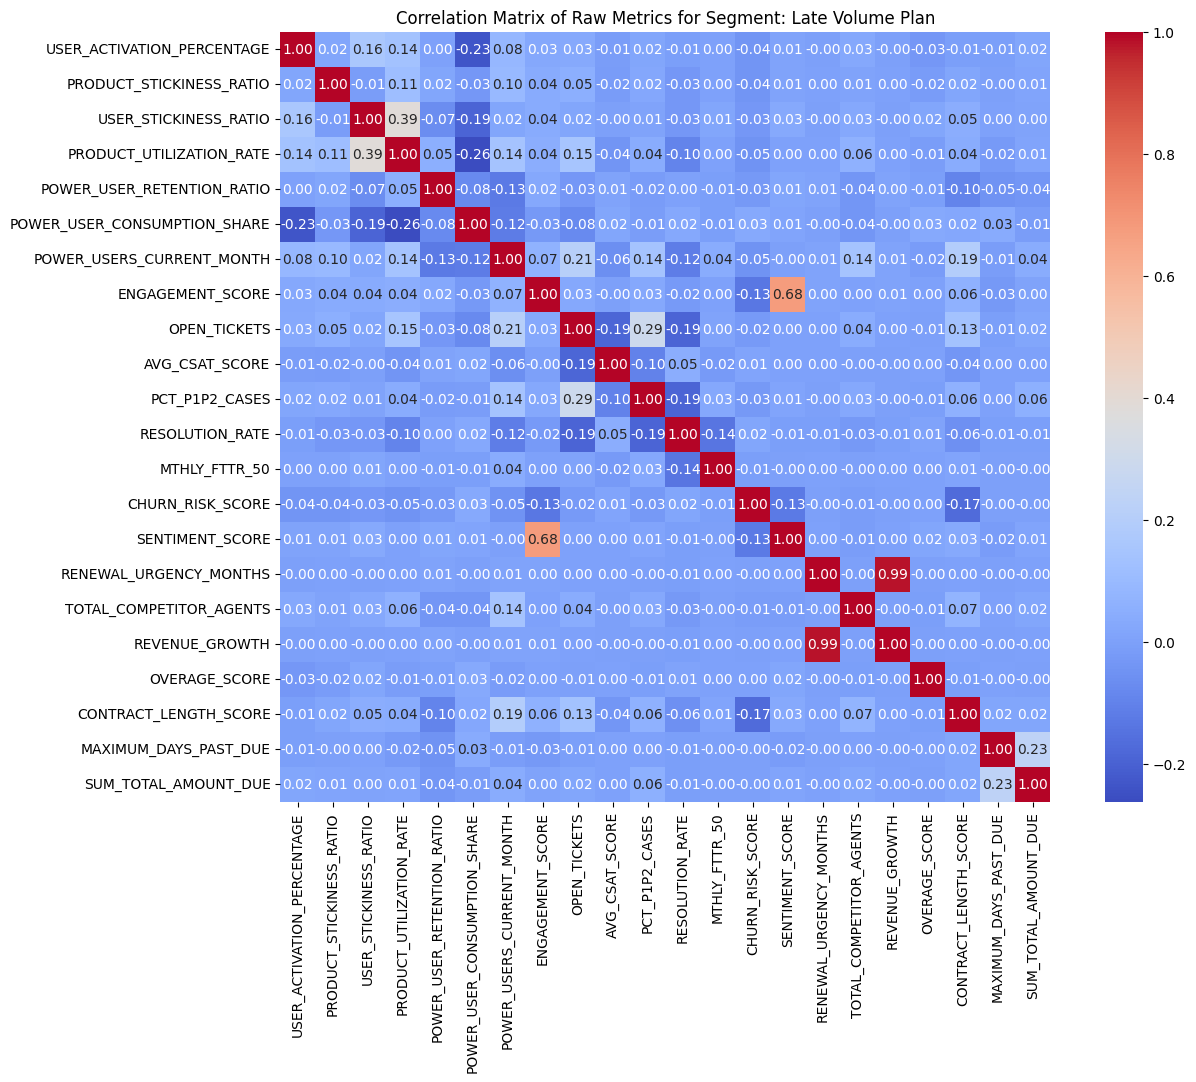

,feature,VIF
9,AVG_CSAT_SCORE,104.244990
14,SENTIMENT_SCORE,46.722943
7,ENGAGEMENT_SCORE,46.125810
15,RENEWAL_URGENCY_MONTHS,33.926329
17,REVENUE_GROWTH,33.924393
11,RESOLUTION_RATE,25.863928
1,PRODUCT_STICKINESS_RATIO,14.092079
13,CHURN_RISK_SCORE,11.273504
4,POWER_USER_RETENTION_RATIO,10.298418
5,POWER_USER_CONSUMPTION_SHARE,7.194852


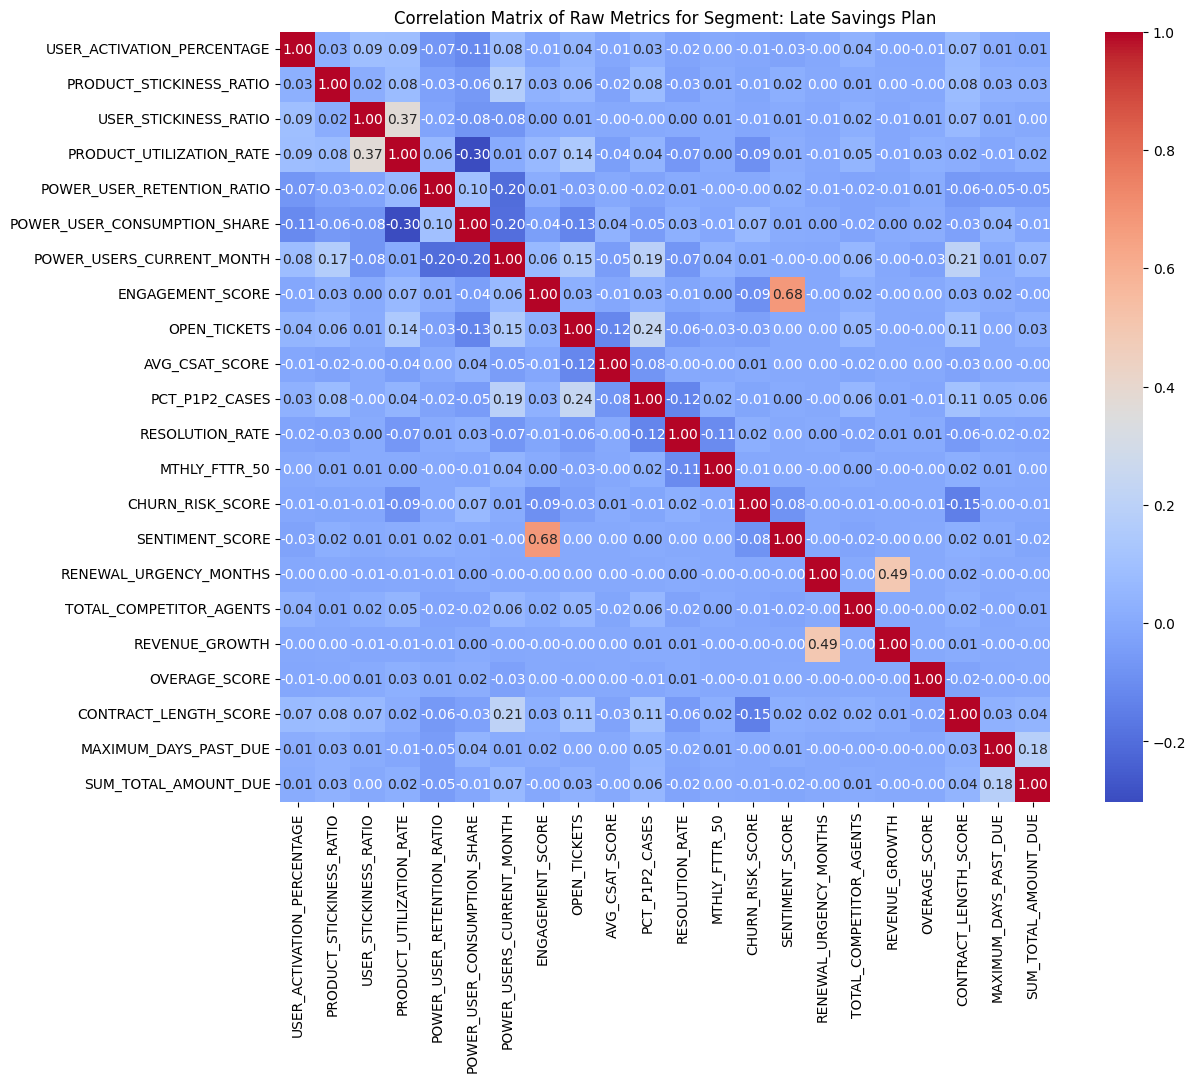

,feature,VIF
9,AVG_CSAT_SCORE,69.429866
7,ENGAGEMENT_SCORE,66.279568
14,SENTIMENT_SCORE,46.742643
1,PRODUCT_STICKINESS_RATIO,15.174308
11,RESOLUTION_RATE,11.595695
4,POWER_USER_RETENTION_RATIO,10.099454
6,POWER_USERS_CURRENT_MONTH,7.430169
5,POWER_USER_CONSUMPTION_SHARE,6.723631
19,CONTRACT_LENGTH_SCORE,5.417761
18,OVERAGE_SCORE,3.897514


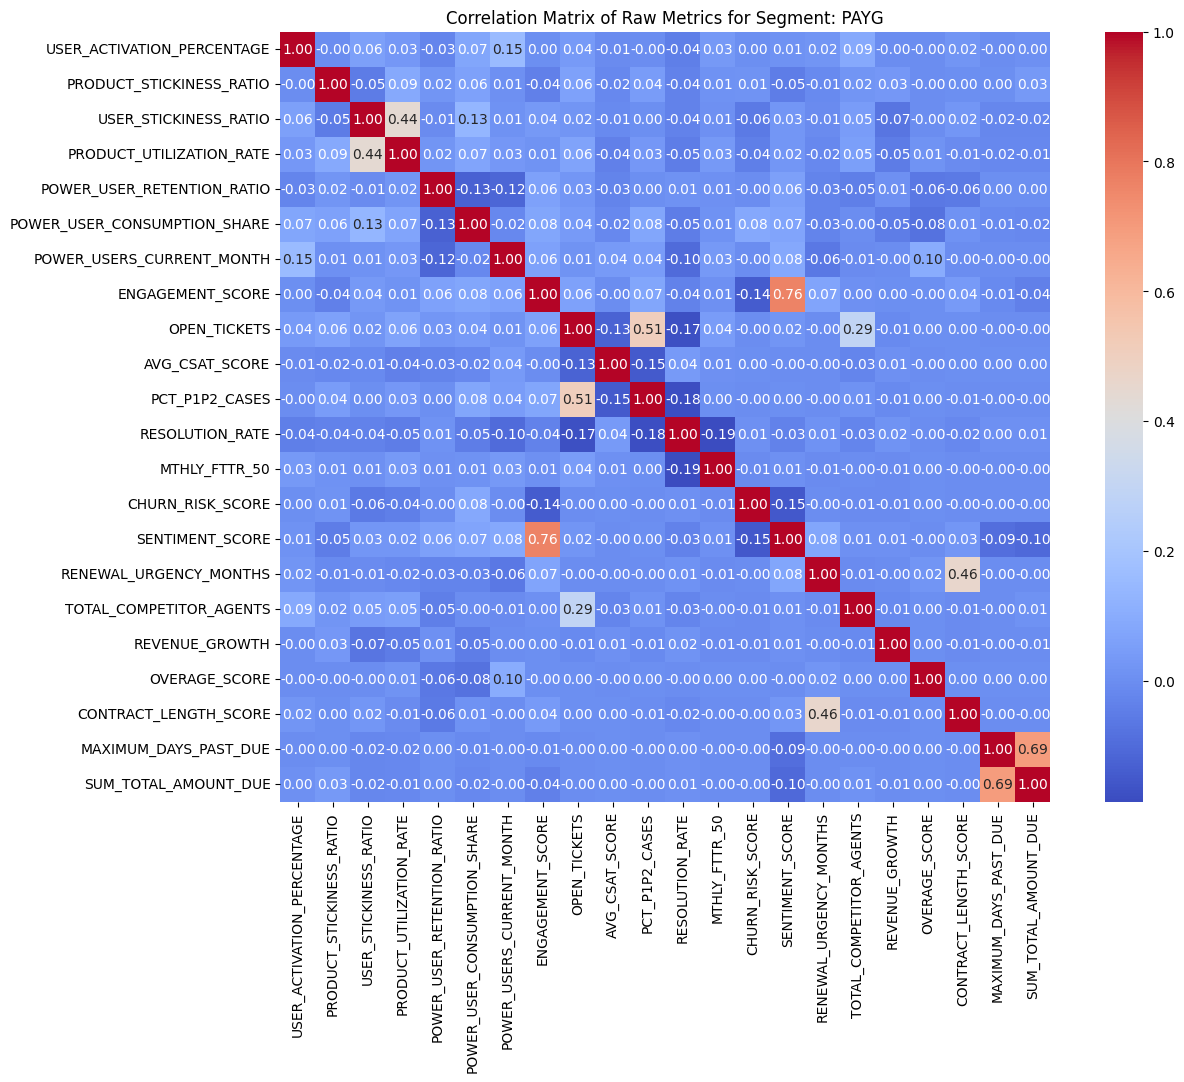

,feature,VIF
18,OVERAGE_SCORE,1194.601655
9,AVG_CSAT_SCORE,978.007861
19,CONTRACT_LENGTH_SCORE,170.681309
7,ENGAGEMENT_SCORE,84.272782
14,SENTIMENT_SCORE,72.005510
11,RESOLUTION_RATE,62.523684
4,POWER_USER_RETENTION_RATIO,34.016379
13,CHURN_RISK_SCORE,32.280271
6,POWER_USERS_CURRENT_MONTH,24.957840
1,PRODUCT_STICKINESS_RATIO,17.874964


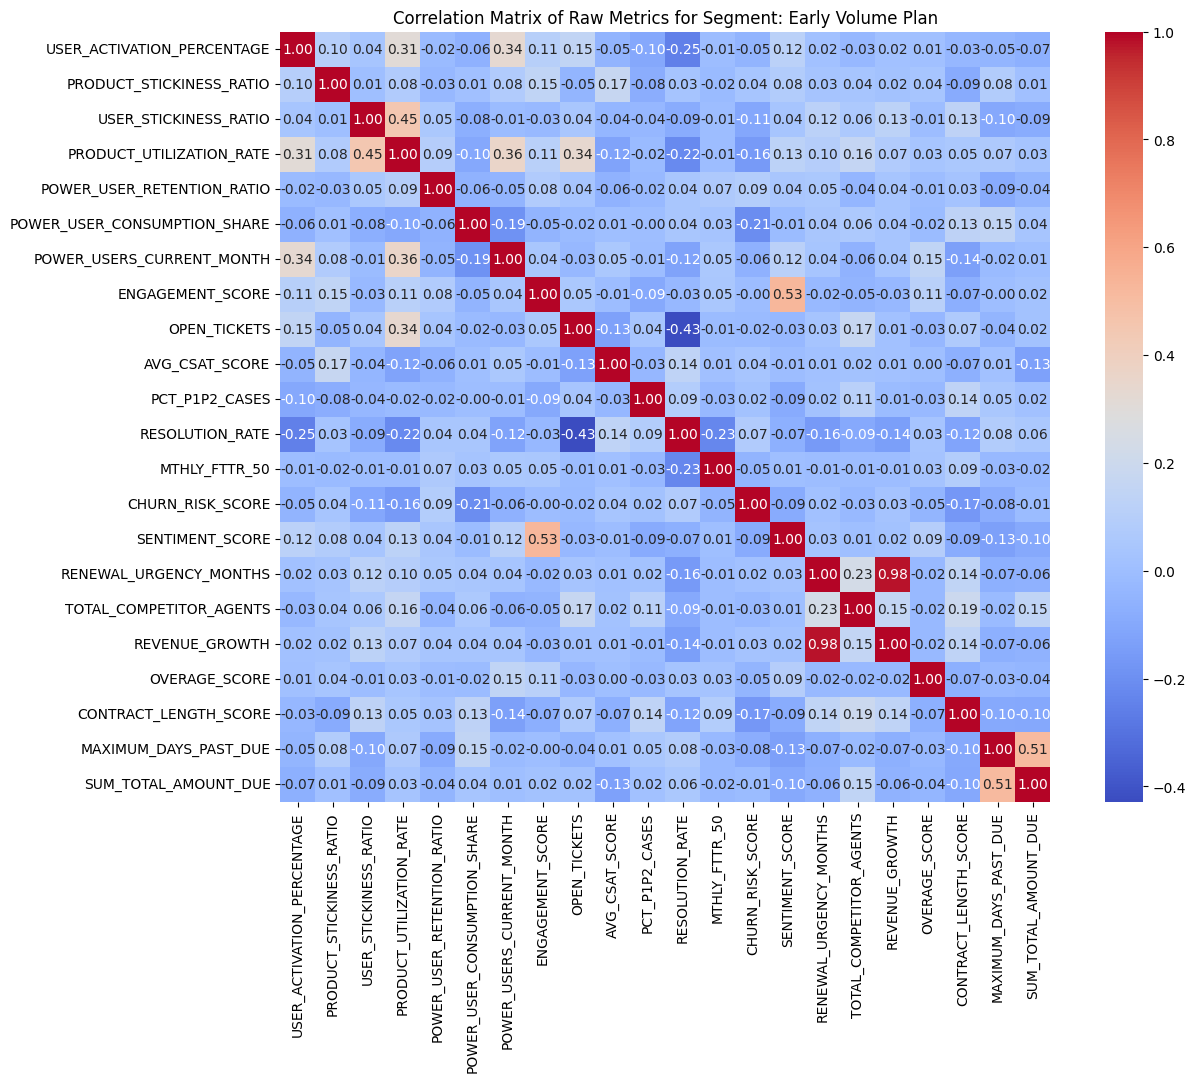

,feature,VIF
9,AVG_CSAT_SCORE,102.222613
7,ENGAGEMENT_SCORE,40.254098
14,SENTIMENT_SCORE,35.710995
15,RENEWAL_URGENCY_MONTHS,30.582737
17,REVENUE_GROWTH,29.526254
11,RESOLUTION_RATE,20.168662
10,PCT_P1P2_CASES,13.489635
6,POWER_USERS_CURRENT_MONTH,8.602422
1,PRODUCT_STICKINESS_RATIO,7.637329
5,POWER_USER_CONSUMPTION_SHARE,6.339639


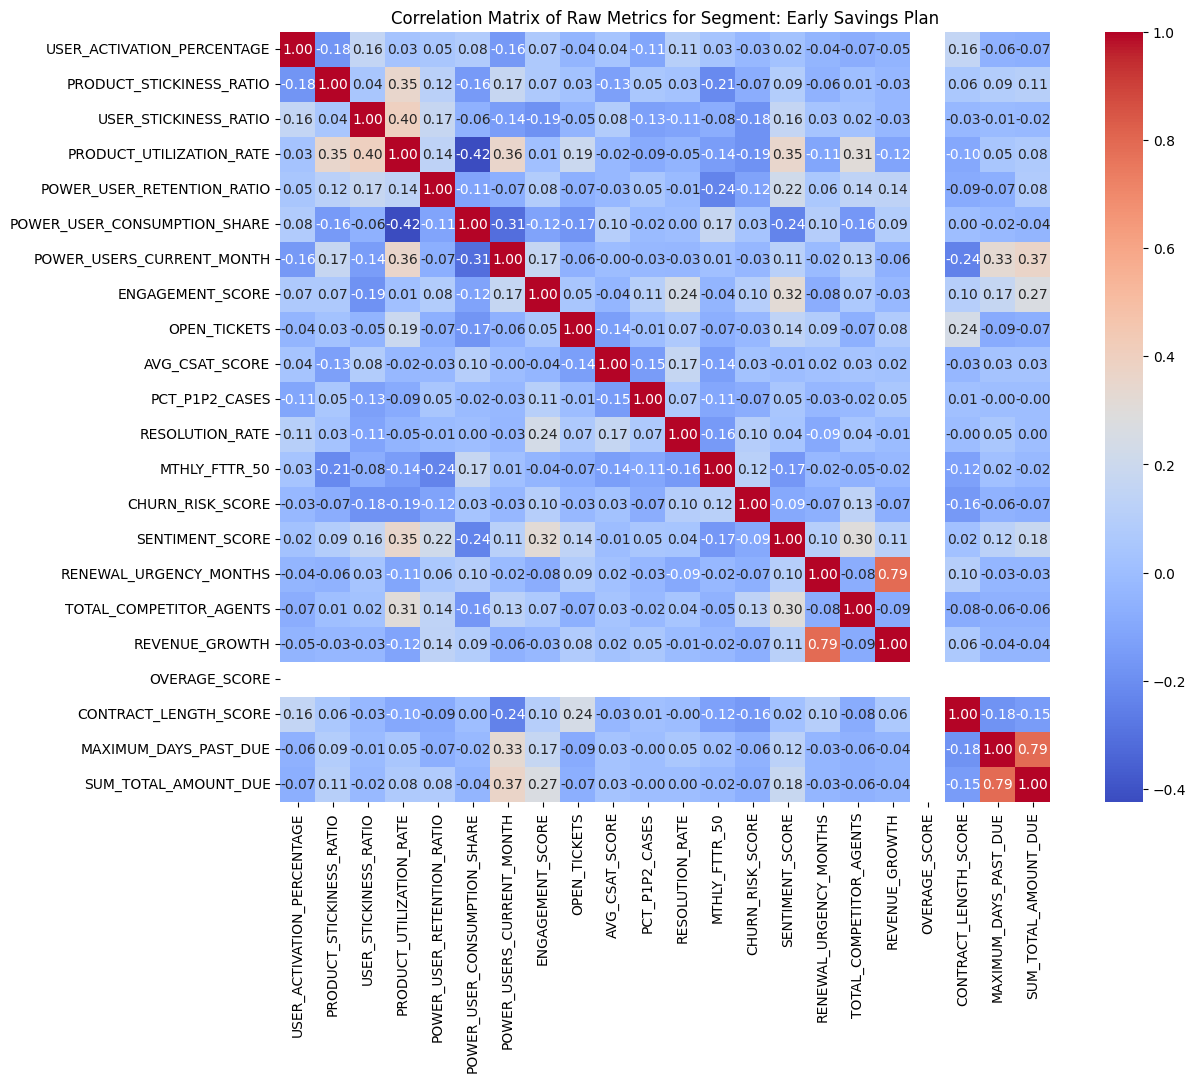

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:


# Correlation matrix for raw_columns
for segment in df_cleaned['SEGMENT_NAME'].unique():
    seg_df = df_cleaned[df_cleaned['SEGMENT_NAME'] == segment]
    corr_matrix = seg_df[raw_columns].corr()
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Matrix of Raw Metrics for Segment: " + segment)
    plt.show()

# Calculate VIF for each raw metric

# Drop rows with any NaN in raw_columns for VIF calculation
    X_vif = seg_df[raw_columns].dropna().copy()
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    vif_data = vif_data.sort_values(by="VIF", ascending=False)
    display(vif_data)

In [24]:
len(raw_columns)

17

In [17]:

df_raw.groupby('SEGMENT_NAME')['SUBSCRIPTION_ACCOUNT_ID'].nunique()


SEGMENT_NAME
Early Savings Plan      33
Early Volume Plan       71
Late Savings Plan     1466
Late Volume Plan      1811
PAYG                   331
Name: SUBSCRIPTION_ACCOUNT_ID, dtype: int64

In [25]:
raw_columns

['USER_ACTIVATION_PERCENTAGE',
 'PRODUCT_STICKINESS_RATIO',
 'USER_STICKINESS_RATIO',
 'PRODUCT_UTILIZATION_RATE',
 'ENGAGEMENT_SCORE',
 'OPEN_TICKETS',
 'AVG_CSAT_SCORE',
 'PCT_P1_CASES',
 'PCT_P1P2_CASES',
 'RESOLUTION_RATE',
 'CHURN_RISK_SCORE',
 'SENTIMENT_SCORE',
 'RENEWAL_URGENCY_MONTHS',
 'MTHLY_FTTR_50',
 'REVENUE_GROWTH',
 'OVERAGE_SCORE',
 'CONTRACT_LENGTH_SCORE']

You should use the raw scores for your regression analysis, not the capped, normalized scores.

The primary reason is that the capping and normalization process intentionally throws away information. By capping scores at the 1st and 99th percentiles, you are treating an extreme outlier the same as a mild outlier (e.g., a score at the 99.1 percentile is treated identically to a score at the 99.9 percentile). This loss of variance can weaken the signal in your data, making it harder for the regression model to detect the true linear relationship. Linear regression thrives on the continuous variance of raw data to find the best fit.

The capping logic is excellent for creating a bounded "health score" for dashboards or business reporting, but for statistical modeling, you want to give the model the most detailed, untransformed information available.

## An Efficient Approach for Feature Importance with 18+ Metrics
Trying to add features one-by-one (forward selection) is very time-consuming and can lead to misleading results, especially with many correlated features. A more robust and efficient approach involves checking for multicollinearity and then using a model that can perform feature selection for you.

Here’s a step-by-step guide:

1. Data Preparation
Start with Raw Scores: Use the raw, uncapped scores for all 18 of your input metrics.
Handle Missing Values: Decide on a strategy for any missing data (e.g., imputation with the mean or median, or more advanced methods).
Standardize Your Data: Before feeding the data into the model, scale all your raw scores. Using a StandardScaler (which transforms data to have a mean of 0 and a standard deviation of 1) is crucial for the next step to work effectively.
2. Check for Multicollinearity
With 18 metrics, it's very likely that some are highly correlated with each other (e.g., "daily active users" and "weekly active users"). High correlation, or multicollinearity, can make p-values and feature importance unreliable.

Calculate a Correlation Matrix: Quickly visualize the relationships between all your raw metrics.
Use Variance Inflation Factor (VIF): This is the standard method. VIF measures how much the variance of an estimated regression coefficient is increased because of collinearity.
Calculate the VIF for each feature.
A common rule of thumb is that a VIF score above 5 or 10 indicates high multicollinearity.
If you find highly correlated features, consider removing one of them from each correlated pair. For example, if two metrics have a VIF of 20 and are highly correlated, keep the one that makes more business sense or has a slightly stronger individual correlation with your target variable.
3. Automated Feature Selection with Lasso Regression
Instead of manually adding features one by one, use Lasso (L1) Regression. Lasso is a type of linear regression that includes a penalty term that forces the coefficients of the least important features to become exactly zero, effectively removing them from the model. This makes it an excellent and highly efficient tool for automated feature selection.

Fit a Lasso Model: Train a Lasso regression model using your standardized raw scores as input and your revenue growth as the target.
Tune the Alpha Parameter: The strength of the Lasso penalty is controlled by a parameter called alpha. You can use cross-validation (LassoCV in Scikit-learn) to find the optimal alpha that provides the best model performance.
Identify Important Features: After fitting the model, inspect the coefficients. The features that still have a non-zero coefficient are the ones the Lasso model has selected as important. The features whose coefficients were shrunk to zero are considered less significant.
4. Final R-squared and P-value Analysis
Now that Lasso has helped you identify the most promising subset of features, you can perform a final, traditional linear regression to get the clear R-squared and p-values you want.

Build a Final Multiple Regression Model: Use only the features that were selected by the Lasso model (those with non-zero coefficients).
Analyze the Output:
R-squared / Adjusted R-squared: This tells you how much of the variance in your revenue growth is explained by your selected features.
P-values: Now you can confidently look at the p-values for each feature in this final model. Because you've already handled multicollinearity and selected the most impactful variables, these p-values will be much more reliable. Any feature with a p-value above your significance threshold (e.g., 0.05) could still be considered for removal for the most parsimonious model.

In [98]:


rf_feature_importances = {}

for segment in df_cleaned['SEGMENT_NAME'].unique():
    seg_df = df_cleaned[df_cleaned['SEGMENT_NAME'] == segment]
    X = seg_df[raw_columns].apply(pd.to_numeric, errors='coerce')
    y = pd.to_numeric(seg_df['PCT_M_PLUS_6_BCM'], errors='coerce')
    # Drop rows with any NaN in X or y
    valid = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[valid]
    y = y[valid]
    if len(X) == 0 or len(y) == 0:
        print(f"Segment '{segment}' has no valid rows after filtering. Skipping.")
        continue
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    rf_feature_importances[segment] = importance_df
    print(f"\nRandom Forest Feature Importances for segment: {segment}")
    print(importance_df)



Random Forest Feature Importances for segment: Late Volume Plan
                         feature  importance
17                REVENUE_GROWTH    0.699264
12                 MTHLY_FTTR_50    0.058572
15        RENEWAL_URGENCY_MONTHS    0.052534
14               SENTIMENT_SCORE    0.032217
1       PRODUCT_STICKINESS_RATIO    0.031759
7               ENGAGEMENT_SCORE    0.031344
16       TOTAL_COMPETITOR_AGENTS    0.024087
3       PRODUCT_UTILIZATION_RATE    0.020908
5   POWER_USER_CONSUMPTION_SHARE    0.012045
2          USER_STICKINESS_RATIO    0.011050
19         CONTRACT_LENGTH_SCORE    0.007440
6      POWER_USERS_CURRENT_MONTH    0.006843
0     USER_ACTIVATION_PERCENTAGE    0.006003
4     POWER_USER_RETENTION_RATIO    0.004149
13              CHURN_RISK_SCORE    0.000683
18                 OVERAGE_SCORE    0.000463
11               RESOLUTION_RATE    0.000362
8                   OPEN_TICKETS    0.000193
10                PCT_P1P2_CASES    0.000041
21          SUM_TOTAL_AMOUNT_DUE   

In [ ]:
len(raw_columns)

In [ ]:

df_raw.groupby('SEGMENT_NAME')['SUBSCRIPTION_ACCOUNT_ID'].nunique()


In [ ]:
raw_columns

You should use the raw scores for your regression analysis, not the capped, normalized scores.

The primary reason is that the capping and normalization process intentionally throws away information. By capping scores at the 1st and 99th percentiles, you are treating an extreme outlier the same as a mild outlier (e.g., a score at the 99.1 percentile is treated identically to a score at the 99.9 percentile). This loss of variance can weaken the signal in your data, making it harder for the regression model to detect the true linear relationship. Linear regression thrives on the continuous variance of raw data to find the best fit.

The capping logic is excellent for creating a bounded "health score" for dashboards or business reporting, but for statistical modeling, you want to give the model the most detailed, untransformed information available.

## An Efficient Approach for Feature Importance with 18+ Metrics
Trying to add features one-by-one (forward selection) is very time-consuming and can lead to misleading results, especially with many correlated features. A more robust and efficient approach involves checking for multicollinearity and then using a model that can perform feature selection for you.

Here’s a step-by-step guide:

1. Data Preparation
Start with Raw Scores: Use the raw, uncapped scores for all 18 of your input metrics.
Handle Missing Values: Decide on a strategy for any missing data (e.g., imputation with the mean or median, or more advanced methods).
Standardize Your Data: Before feeding the data into the model, scale all your raw scores. Using a StandardScaler (which transforms data to have a mean of 0 and a standard deviation of 1) is crucial for the next step to work effectively.
2. Check for Multicollinearity
With 18 metrics, it's very likely that some are highly correlated with each other (e.g., "daily active users" and "weekly active users"). High correlation, or multicollinearity, can make p-values and feature importance unreliable.

Calculate a Correlation Matrix: Quickly visualize the relationships between all your raw metrics.
Use Variance Inflation Factor (VIF): This is the standard method. VIF measures how much the variance of an estimated regression coefficient is increased because of collinearity.
Calculate the VIF for each feature.
A common rule of thumb is that a VIF score above 5 or 10 indicates high multicollinearity.
If you find highly correlated features, consider removing one of them from each correlated pair. For example, if two metrics have a VIF of 20 and are highly correlated, keep the one that makes more business sense or has a slightly stronger individual correlation with your target variable.
3. Automated Feature Selection with Lasso Regression
Instead of manually adding features one by one, use Lasso (L1) Regression. Lasso is a type of linear regression that includes a penalty term that forces the coefficients of the least important features to become exactly zero, effectively removing them from the model. This makes it an excellent and highly efficient tool for automated feature selection.

Fit a Lasso Model: Train a Lasso regression model using your standardized raw scores as input and your revenue growth as the target.
Tune the Alpha Parameter: The strength of the Lasso penalty is controlled by a parameter called alpha. You can use cross-validation (LassoCV in Scikit-learn) to find the optimal alpha that provides the best model performance.
Identify Important Features: After fitting the model, inspect the coefficients. The features that still have a non-zero coefficient are the ones the Lasso model has selected as important. The features whose coefficients were shrunk to zero are considered less significant.
4. Final R-squared and P-value Analysis
Now that Lasso has helped you identify the most promising subset of features, you can perform a final, traditional linear regression to get the clear R-squared and p-values you want.

Build a Final Multiple Regression Model: Use only the features that were selected by the Lasso model (those with non-zero coefficients).
Analyze the Output:
R-squared / Adjusted R-squared: This tells you how much of the variance in your revenue growth is explained by your selected features.
P-values: Now you can confidently look at the p-values for each feature in this final model. Because you've already handled multicollinearity and selected the most impactful variables, these p-values will be much more reliable. Any feature with a p-value above your significance threshold (e.g., 0.05) could still be considered for removal for the most parsimonious model.